In [29]:
import sys
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import flopy
import pyemu

In [2]:
npar = 100
nrow,ncol = 28,28

In [3]:
gen_name = "gen_250.h5"
gen_d = "gen_models"
generator = keras.models.load_model(os.path.join(gen_d,gen_name))

### (optional) select a new truth

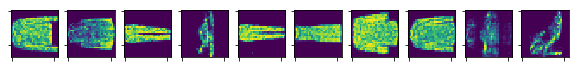

In [4]:
np.random.seed = 1131
truths = np.random.randn(10,npar)
truth_vecs = generator.predict(truths)
fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
for ax,vec in zip(axes.flatten(),truth_vecs.reshape(10,28,28)):
    ax.imshow(vec.transpose())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

In [5]:
truth = truths[4]
truth_vec = truth_vecs[4].reshape(nrow,ncol).transpose()
# need to uncomment these two line to save your new truth
#np.savetxt("hk_truth.ref",truth_vec,fmt="%15.6E")
#np.savetxt("stn_truth.dat",truth,fmt="%15.6E")

### load the truth

(28, 28)

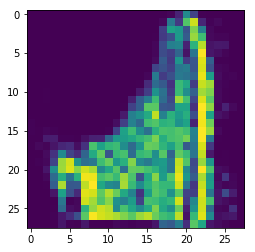

In [6]:
truth_vec = np.loadtxt("hk_truth.ref")
truth = np.loadtxt("stn_truth.dat")
plt.imshow(truth_vec)
truth_vec.shape

### create the modflow model, using the hk truth (in log space)

FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: fashion.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/11/07 11:03:43

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/11/07 11:03:43
 Elapsed run time:  0.011 Seconds

  Normal termination of simulation


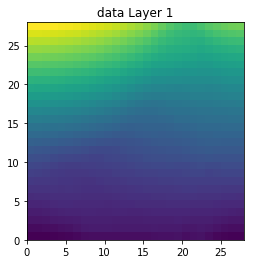

In [7]:

m = flopy.modflow.Modflow("fashion",model_ws="temp",exe_name="mfnwt",version="mfnwt")
d = flopy.modflow.ModflowDis(m,nrow=nrow,ncol=ncol,nlay=1,delr=1,delc=1,top=10,botm=0)
b = flopy.modflow.ModflowBas(m,strt=10)
u = flopy.modflow.ModflowUpw(m,hk=10**truth_vec)
n = flopy.modflow.ModflowNwt(m)
o = flopy.modflow.ModflowOc(m,stress_period_data={(0,0):["save head", "save budget"]})
wel_data = [[0,0,j,10.0] for j in range(ncol)]
w = flopy.modflow.ModflowWel(m,stress_period_data=wel_data)
riv_data = [[0,nrow-1,j,5,10,0] for j in range(ncol)]
r = flopy.modflow.ModflowRiv(m,stress_period_data=riv_data)
m.write_input()
m.run_model()
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"))
hds.plot()

### setup the pest interface

In [8]:
ph = pyemu.helpers.PstFromFlopyModel("fashion.nam",org_model_ws="temp",new_model_ws="template", remove_existing=True,
                                     model_exe_name="mfnwt",hds_kperk=[[0,0]])

2018-11-07 11:03:43.997002 starting: loading flopy model

Creating new model with name: fashion
--------------------------------------------------

Parsing the namefile --> temp/fashion.nam

--------------------------------------------------
External unit dictionary:
{2: filename:temp/fashion.list, filetype:LIST, 11: filename:temp/fashion.dis, filetype:DIS, 13: filename:temp/fashion.bas, filetype:BAS6, 31: filename:temp/fashion.upw, filetype:UPW, 32: filename:temp/fashion.nwt, filetype:NWT, 14: filename:temp/fashion.oc, filetype:OC, 20: filename:temp/fashion.wel, filetype:WEL, 18: filename:temp/fashion.riv, filetype:RIV, 51: filename:temp/fashion.hds, filetype:DATA(BINARY)}
--------------------------------------------------

ModflowBas6 free format:True

loading dis package file...
   Loading dis package with:
      1 layers, 28 rows, 28 columns, and 1 stress periods
   loading laycbd...
   loading delr...
   loading delc...
   loading top...
   loading botm...
      for 1 layers and 0

/Users/jeremyw/Dev/pyemu/pyemu/logger.py:108: PyemuWarning: 2018-11-07 11:03:44.010900 WARNING: removing existing 'new_model_ws

  warnings.warn(s,PyemuWarning)



creating model workspace...
   template

changing model workspace...
   template
2018-11-07 11:03:45.033991 starting: writing new modflow input files

Writing packages:
   Package:  DIS
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
   Package:  BAS6
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
   Package:  UPW
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
   Package:  NWT
   Package:  OC
   Package:  WEL
   Package:  RIV
 
2018-11-07 11:03:45.086427 finished: writing new modflow input files took: 0:00:00.052436
2018-11-07 11:03:45.086882 forward_run line:pyemu.os_utils.run('mfnwt fashion.nam 1>fashion.nam.stdout 2>fashion.nam.stderr')
2018-11-07 11:03:45.087254 starting: setting up 'template/arr_org' dir
2018-11-07 11:03:45.087419 finished: setting up 'template/arr_org'

/Users/jeremyw/Dev/pyemu/pyemu/pst/pst_handler.py:1219: PyemuWarning: no adjustable pars
  warnings.warn("no adjustable pars",PyemuWarning)


write a generic template file to hold the generative model input vector

In [9]:
with open(os.path.join(ph.m.model_ws,"par.dat.tpl"),'w') as f:
    f.write("ptf ~\n")
    [f.write("~ par_{0:03d}   ~\n".format(ipar)) for ipar in range(npar)]
with open(os.path.join(ph.m.model_ws,"par.dat"),'w') as f:
    [f.write("{0:15.6E}\n".format(ipar)) for ipar in truth] # write the truth values for testing  


In [10]:
df = ph.pst.add_parameters(os.path.join(ph.m.model_ws,"par.dat.tpl"),pst_path='.')


In [11]:
par = ph.pst.parameter_data
par.sort_values("parnme",inplace=True)
par.loc[:,"parubnd"] = 4.0
par.loc[:,"parlbnd"] = -4.0
par.loc[:,"partrans"] = "none"
par.loc[:,"parval1"] = truth
#par.parval1,truth

Write an instruction file to read the hk array as observations so we can track what is happening

In [12]:
ins_file = os.path.join(ph.m.model_ws,"hk_Layer_1.ref.ins")
with open(ins_file,'w') as f:
    f.write("pif ~\n")
    for i in range(nrow):
        f.write("l1 ")
        for j in range(ncol):
            oname = "hk_{0:03d}_{1:03d}".format(i,j)
            f.write(" !{0}!".format(oname))
        f.write("\n")
df = ph.pst.add_observations(ins_file,ins_file.replace(".ins",""),pst_path='.')


 write a function to call the generative model, run the current par values and save the resulting vector as the hk array

In [13]:
with open(os.path.join(ph.m.model_ws,"apply_gan.py"),'w') as f:
    f.write("import numpy as np\nimport keras\n")
    f.write("def apply():\n")
    f.write("    gen = keras.models.load_model('{0}')\n".format(gen_name))
    f.write("    vals = np.atleast_2d(np.loadtxt('par.dat'))\n") 
    f.write("    print(vals.shape)\n")
    f.write("    vec = gen.predict(vals).reshape({0},{1}).transpose()\n".format(nrow,ncol)) #note the transpose!!!
    f.write("    np.savetxt('hk_Layer_1.ref',10**vec)\n")
    f.write("    return vec")
shutil.copy2(os.path.join(gen_d,gen_name),os.path.join(ph.m.model_ws,gen_name))  

'template/gen_250.h5'

test run the apply function

(1, 100)


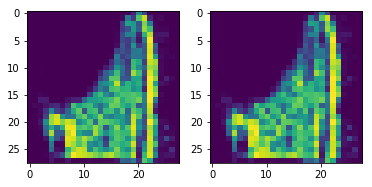

In [14]:
bd = os.getcwd()
try:
    
    os.chdir(ph.m.model_ws)
    import apply_gan
    import importlib # incase apply_gan.py has changed...
    importlib.reload(apply_gan)
    hk = apply_gan.apply()
except Exception as e:
    print(str(e))
    os.chdir(bd)

os.chdir(bd)

ax1,ax2 = plt.subplot(121), plt.subplot(122)
ax1.imshow(hk)
ax2.imshow(truth_vec)
plt.show()

If everything is working, those two "hk arrays" should be the same

### setup some observations

,obsnme,i,j
hds_00_001_007_000,hds_00_001_007_000,1,7
hds_00_003_016_000,hds_00_003_016_000,3,16
hds_00_005_025_000,hds_00_005_025_000,5,25
hds_00_008_006_000,hds_00_008_006_000,8,6
hds_00_010_015_000,hds_00_010_015_000,10,15
hds_00_012_024_000,hds_00_012_024_000,12,24
hds_00_015_005_000,hds_00_015_005_000,15,5
hds_00_017_014_000,hds_00_017_014_000,17,14
hds_00_019_023_000,hds_00_019_023_000,19,23
hds_00_022_004_000,hds_00_022_004_000,22,4


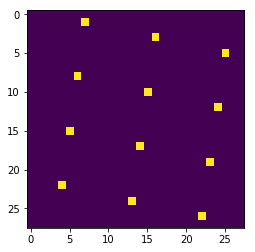

In [15]:
obs = ph.pst.observation_data
obs.loc[:,"weight"] = 0.0
hds = obs.loc[obs.obgnme=="hds",["obsnme"]][35::65].copy()
hds.loc[:,"i"] = hds.obsnme.apply(lambda x: int(x.split('_')[2]))
hds.loc[:,"j"] = hds.obsnme.apply(lambda x: int(x.split('_')[3]))

arr = np.zeros((nrow,ncol))
arr[hds.i,hds.j] = 1.0
plt.imshow(arr)
hds

In [16]:
ph.pst.observation_data.loc[hds.index,"weight"] = 1.0

In [17]:
ph.frun_pre_lines.append("import apply_gan")
ph.frun_pre_lines.append("apply_gan.apply()")
ph.tmp_files.append("hk_Layer_1.ref")

In [18]:
ph.pst.write(os.path.join(ph.m.model_ws,"fashion.pst"))
ph.write_forward_run()

noptmax: 0


An noptmax=0 test run...

In [19]:
pyemu.os_utils.run("pestpp fashion.pst",cwd=ph.m.model_ws)

2.244036897953384e-11

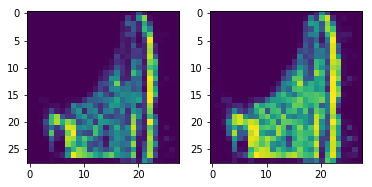

In [20]:
pst = pyemu.Pst(os.path.join(ph.m.model_ws,"fashion.pst"))
hk_res = pst.res.loc[pst.res.name.apply(lambda x: x.startswith("hk")),:].copy()
hk_res.loc[:,"i"] = hk_res.name.apply(lambda x: int(x.split('_')[1]))
hk_res.loc[:,"j"] = hk_res.name.apply(lambda x: int(x.split('_')[2]))
arr = np.zeros((nrow,ncol))
arr[hk_res.i,hk_res.j] = hk_res.modelled
ax1,ax2 = plt.subplot(121),plt.subplot(122)
ax1.imshow(arr)
ax2.imshow(truth_vec)
pst.phi

If everything is working, then phi should be really small and the simulated hk array should look like the truth

now for some ies fun...

In [21]:
pst.parameter_data.loc[:,"parval1"] = 1.0 #so the base real doesn't fit perfectly
pst.pestpp_options = {}
pst.pestpp_options["par_sigma_range"] = 8.0
pst.pestpp_options["ies_num_reals"] = 50
pst.pestpp_options["ies_lambda_mults"] = [0.1,1.0,2.0]
pst.pestpp_options["lambda_scale_fac"] = [0.5,0.75,1.0]
pst.control_data.noptmax = 6
pst.write(os.path.join(ph.m.model_ws,"fashion_ies.pst"))

noptmax: 6


In [26]:
m_d = "ies_master"
pyemu.os_utils.start_slaves("template","pestpp-ies","fashion_ies.pst",num_slaves=20,master_dir=m_d)

In [ ]:
obs_en_names = [f for f in os.listdir(m_d) if f.endswith(".obs.csv") and "base" not in f]
obs_en = [pd.read_csv(os.path.join(m_d,f)) for f in obs_en_names]

In [53]:
from matplotlib.backends.backend_pdf import PdfPages

(18, 12) 18


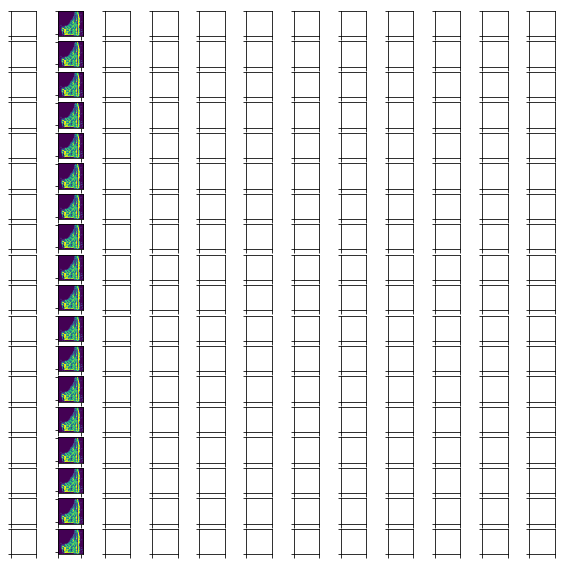

In [54]:
#pdf = PdfPages(os.path.join(m_d,"iter_compare.pdf"))
plt.close("all")
plt_rows = len(obs_en)
fig,axes = plt.subplots(nrows=plt_rows,ncols=12,figsize=(10,10),subplot_kw={"aspect":"equal"})
print(axes.shape,len(obs_en))
for i,obs_en in enumerate(obs_en):
    ax = axes[i,1]
    ax.imshow(truth_vec)
for ax in axes.flatten():
   ax.set_xticklabels([])
   ax.set_yticklabels([])